# Regression

In [1]:
%load_ext autoreload
%autoreload 2
import latenta as la
import numpy as np

We'll use the same dataset as [before](./1-variables)...

In [2]:
import scanpy as sc

adata = la.data.load_myod1()
adata.obs["log_overexpression"] = np.log1p(adata.obs["overexpression"])
adata.var["label"] = adata.var["symbol"]
adata.raw = adata


## Easy things first: Linear regression

In the last tutorial, we learned the main types of variables, and how to connect these to construct a model:
- You either specify them at initialization: `la.Observation(p = ...)`
- Or connect them afterwards: `observation.p = ...`

We can now use these concepts to build a basic model of a transcriptome:

In [3]:
genes = la.Dim(adata.var)
cells = la.Dim(adata.obs)

We first define our overexpression:

In [4]:
adata.obs["log_overexpression"]

cell
AAAGATGAGGCAATTA-1-5    6.028279
AAATGGAGTACGTACT-1-7    4.276666
AAGACTCTCCGCACTT-1-9    5.902633
AAGGTAATCCTATTTG-1-8    2.772589
AATCGACTCGTTCTGC-1-7    4.442651
                          ...   
TTTATGCCATACGCTA-1-5    0.000000
TTTCACATCCGGGACT-1-7    0.000000
TTTGATCAGATGCAGC-1-8    0.000000
TTTGATCAGCGATCGA-1-8    0.000000
TTTGGAGAGATTGATG-1-8    0.000000
Name: log_overexpression, Length: 799, dtype: float64

In [5]:
overexpression = la.Fixed(adata.obs["log_overexpression"], label="overexpression")

We then define how this overexpression affects our gene expression on average across different cells. To keep things simple, we will first create a linear model that has both a baseline expression $b$ and a slope $a$ for each gene as we did in the previous section on variables. Because gene expression is only defined for positive numbers, we also add an exponential transformation:

In [6]:
expression = la.links.scalar.Linear(
    overexpression,
    a=True,
    b=True,
    label="expression",
    symbol=r"\mu",
    definition=la.Definition([cells, genes]),
    transforms=[la.transforms.Exp()],
)

Although the latent slope and baseline were created automatically for us by specifying `a = True, b = True`, it's important to remember that we could have easily created these variables ourselves, for example:

```python
slope = la.Latent(
    p = la.distributions.Normal(loc = 0.0, scale = la.Parameter(1., transforms = [la.transforms.Exp()])),
    definition = [genes]
)
```

While the `expression` variable models our average expression, what we actually observe is a noisy sample of (UMI) counts. The prototypical way to model this is using a NegativeBinomial2. It has two components, a mean that needs to be positive (hence the exponential transformation from before) and a dispersion that also needs to be positive. This dispersion models the heterogeneity, and as this typically depends on the gene we will model it as a latent variable:

In [7]:
dispersion = la.Latent(
    la.distributions.LogNormal(
        la.Parameter(0.0), la.Parameter(1.0, transforms=[la.transforms.Exp()])
    ),
    definition=la.Definition([genes]),
)

In [8]:
dispersion.p

p: scale, loc ↦ LogNormal [gene (2047)]

Note the LogNormal prior here: this distribution has a _support_ only positive numbers, and latenta will automatically try to match this support in the variational distribution $q$, in this case by adding an exponention transform:

In [9]:
dispersion.q

q: scale, loc ↦ Normal [gene (•)]

We can now define the distribution that our data will follow to model the noisiness:

In [10]:
transcriptome_p = la.distributions.NegativeBinomial2(
    mu=expression, dispersion=dispersion
)

And then we can define our observation, which is the transcriptome (or the counts):

In [11]:
transcriptome = la.Observation(
    adata.X,
    transcriptome_p,
    definition=[cells, genes],
    label="transcriptome",
)

In [12]:
transcriptome.plot()

Note the many free parameters, in grey, that form the leaves of our model. These will have to be estimated by the model. But first, we can ask ourselves why are there so many parameters even for such a simple linear regression?

Let's remind ourselves what we are actually trying to accomplish: create a good model of our observations.


It's true that there are many models that will provide a very good fit of the data equally, even simple ones. For example, we could just give the actual count matrix as input to the negative binomial and this trivial model would fit extremely well. However it would not help us to understand/learn anything from our observations.

So we don't just want a model, we want a model that can explain our observation well, while being both generalizeable and interpretable. And to accomplish this, we have to limit the flexibility that our model can have. You have already done this by specifying two types of priors:

- "Hard" priors are those that completely constrain the model. For example, by specifying a linear function to model our average expression for example, we don't allow any non-linearities. There is no way for the model to move beyond these constraints.
- "Soft" priors are those that push the latent variables towards more likely values. For example, as we discussed previously, we want to discourage extreme slopes that are far away from 0 (as it's unlikely for most genes), unless the data provides strong evidence for a gene to have an extrem slope. We can do so by specifying a distribution of likely slope values using the prior distribution $p$.

The free parameters will then be estimated so that they balance the wishes of the soft priors to the wishes of the observations:
* the parameters of the variational distributions $q$ will try to explain the observations while also remaining faithful to the prior distributions $p$.
* The parameters of $p$ on the other hand will try to accomodate the parameters of $q$ as well as possible, but it cannot do this perfectly as these parameters are shared across all genes.

It's this pushing and pulling between priors and variational distributions that prevent overfitting and underfitting of the model. At the same time, we get some estimates of the uncertainty of our latent variables for free!

Mathematically speaking, the "wishes of the observations" is called the **likelihood** and noted by $P(x|z)$ the probability of observing $x$ given $z$, where $x$ are the observations and $z$ the latent variables. The "wishes of the prior" on the other hand is called the **prior probability** and noted by $P(z)$.

 To infer an optimal value for these parameters, we have to find a solution that best balances the needs of the prior distribution with those of the observations. And one of the fastest ways to do that is to use gradient descent, which starts from an initial value and then tries to move these initial values slowly but surely into values fitting the model better.

These tasks are fullfilled by:
* a loss function (`ELBO`), represents the "cost" of our observation. An optimization problem seeks to minimize it.
* an optimizer (`Adam`), tries to select the best values with regards to our priors/constrains
* an overarching training class (`SVI`):

In [13]:
inference = la.infer.svi.SVI(
    transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)

We can now train for a couple of iterations or until the loss function has reached convergence:

  0%|                                                                                                         …

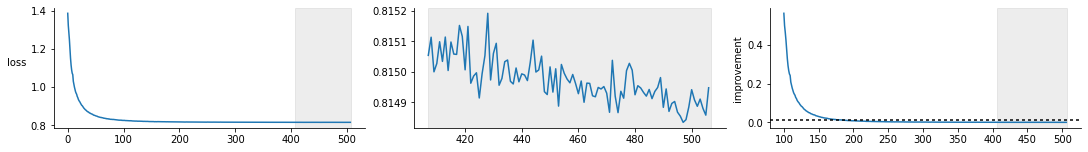

In [14]:
trace = trainer.train(10000)
trace.plot()

We can see that the values have changed.

Several different parameters had to be estimated, remember the ones, in grey, at the top of our graph structure. Let's for example look at the mean values of the slope , we can trace back using the graph structures to access this value: the mean (`.loc`), of the posterior distribution (`.q`) of the slope (`.a`) of the linear model which models the average expression (`.mu`) of the distribution that models our transcriptome (`.p`)

In [15]:
transcriptome.p.mu.a.q.loc.run()
transcriptome.p.mu.a.q.loc.value_pd.head()

gene
ENSMUSG00000000031    1.096454
ENSMUSG00000000058   -0.156195
ENSMUSG00000000078   -0.084666
ENSMUSG00000000184   -0.030851
ENSMUSG00000000202    1.002237
dtype: float32

Note that you need to `.run()` before being able to access the values.

Our inference algorithm did not fullfill all 10000 iterations, but has permaturely stopped as it has detected _convergence_. Do note that this converge is not always perfect, and we will see later that there are some circumstances where further training may be advisable.

## Interpreting a regression model

For interpretation of the model, we can then use 3 main types of posteriors:
* Observed posterios
* Causal posteriors
* Perturbed posteriors

### 1. Observed posteriors

Because we are working with a probabilistic model, every time we run through the model our results will change. For example, each time we sample from variational distribution of the slope $q$ the output will be different, which will affect any downstream variables even if they are themselves deterministic. To interpret the results, we thus have to sample multiple times from the model. We can do this using {class}`~latenta.posterior.Observed` followed by the function `.sample()` which takes n samples.

In [16]:
transcriptome_observed = la.posterior.Observed(
    transcriptome, retain_samples={expression.a}
)
transcriptome_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

The sampled values are stored in the dictionary `.samples` containing the samples of each variables if they were mentioned in the `retain_samples` argument. We can access each variable by providing the variable itself. In this example we are interested by `expression.a` which we defined earlier:

In [17]:
transcriptome_observed.samples[expression.a]

<xarray.DataArray 'slope' (sample: 5, gene: 2047)>
array([[ 1.1797125e+00, -4.5625076e-02, -5.5690445e-02, ...,
        -1.4443402e-01, -3.0521160e-01, -4.8026405e-02],
       [ 8.4134734e-01, -1.9618699e-01, -8.1787586e-02, ...,
         1.4892858e-01, -1.0624225e-01,  5.8728281e-02],
       [ 1.1632707e+00, -2.0192264e-01, -7.4746430e-02, ...,
         1.2555867e-03, -3.5316870e-02, -8.3545417e-02],
       [ 1.4639773e+00, -1.7371361e-01, -8.5154235e-02, ...,
        -5.6096867e-02, -1.9666298e-01, -4.8951924e-02],
       [ 1.1114188e+00, -1.6697749e-01, -9.6445337e-02, ...,
        -1.5885475e-01,  9.2107713e-02,  1.3091365e-02]], dtype=float32)
Coordinates:
  * gene     (gene) <U18 'ENSMUSG00000000031' ... 'ENSMUSG00000118365'
Dimensions without coordinates: sample

:::{note}
Latenta makes extensive use of the [xarray](https://xarray.pydata.org/en/stable/) library for annotated data in more than 2 dimensions. All samples are always stored as {py:class}`xarray.DataArray` objects. Important functions to know are:
- {py:meth}`~xarray.DataArray.sel` to select a subset of the data
- {py:meth}`~xarray.DataArray.to_pandas` to convert a 2D or 1D array to a pandas DataFrame or Series
- {py:attr}`~xarray.DataArray.dims` to get the dimensions of the data
- {py:attr}`~xarray.DataArray.values` to get the values as a numpy array
- {py:meth}`~xarray.DataArray.mean` to get the mean across a dimension
- {py:class}`xarray.DataArray` to construct a new DataArray
:::

For example, we might be interested by the genes that are the most affected (the most "differentially expressed") by the overexpression of *Myod1*. We can then get and rank the slopes by their mean value ( mean of the sampled values):

In [18]:
mean_slopes = (
    transcriptome_observed.samples[expression.a]
    .mean("sample")
    .to_pandas()
    .sort_values(ascending=False)
)

scores = mean_slopes.rename("slope").to_frame()
scores["symbol"] = adata.var["symbol"][scores.index]
scores

,slope,symbol
gene,,
ENSMUSG00000030399,1.565401,Ckm
ENSMUSG00000009214,1.496030,Mymk
ENSMUSG00000024803,1.425199,Ankrd1
ENSMUSG00000020908,1.402467,Myh3
ENSMUSG00000099906,1.399434,Gm28653
...,...,...
ENSMUSG00000041552,-0.616399,Ptchd1
ENSMUSG00000086331,-0.651916,Gm16310
ENSMUSG00000022025,-0.687268,Cnmd


### 2. Causal posteriors

To know how one variable influences another, we use a causal posterior. In essence, this posterior will set a variable of your choice to particular values, and then see how an output variables (and any intermediates) are affected. Latenta contains many different types of causal posteriors, which mainly differ in their visualization capabilities. Here we will use a {class}`~latenta.posterior.scalar.ScalarVectorCausal` posterior, because we are studying how a **scalar** variable (one value for each cell, i.e. the overexpression of *Myod1*) impacts a **vector** (gene expression for each cell):

In [19]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression, transcriptome
)
overexpression_causal.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

This posterior also contains samples, but now for some _pseudocells_ with each a distinct value for the `overexpression` variable:

In [20]:
overexpression_causal.samples[overexpression].mean("sample")

<xarray.DataArray 'overexpression' (cell: 100)>
array([0.        , 0.09165025, 0.1833005 , 0.27495077, 0.366601  ,
       0.45825118, 0.54990155, 0.6415518 , 0.733202  , 0.82485235,
       0.91650236, 1.0081528 , 1.0998031 , 1.1914531 , 1.2831036 ,
       1.3747538 , 1.466404  , 1.5580541 , 1.6497047 , 1.7413547 ,
       1.8330047 , 1.9246553 , 2.0163057 , 2.1079557 , 2.1996062 ,
       2.2912562 , 2.3829062 , 2.4745567 , 2.5662074 , 2.6578574 ,
       2.7495077 , 2.841158  , 2.932808  , 3.0244582 , 3.1161082 ,
       3.2077584 , 3.2994094 , 3.3910594 , 3.4827094 , 3.5743594 ,
       3.6660094 , 3.7576604 , 3.8493104 , 3.9409604 , 4.0326114 ,
       4.1242604 , 4.2159114 , 4.3075624 , 4.3992124 , 4.490863  ,
       4.5825124 , 4.674163  , 4.7658124 , 4.8574634 , 4.9491134 ,
       5.040764  , 5.1324143 , 5.2240644 , 5.315715  , 5.4073644 ,
       5.4990153 , 5.5906644 , 5.6823153 , 5.7739654 , 5.865616  ,
       5.957267  , 6.0489163 , 6.1405673 , 6.2322164 , 6.3238673 ,
       6.415517  , 6.507168  , 6.598819  , 6.690469  , 6.782119  ,
       6.873769  , 6.965419  , 7.057069  , 7.14872   , 7.2403708 ,
       7.332019  , 7.4236703 , 7.515321  , 7.606971  , 7.698621  ,
       7.790271  , 7.881921  , 7.973572  , 8.065223  , 8.156874  ,
       8.248522  , 8.340173  , 8.431823  , 8.523474  , 8.615125  ,
       8.706773  , 8.798425  , 8.890075  , 8.981726  , 9.073374  ],
      dtype=float32)
Coordinates:
  * cell     (cell) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99

Depending on the type of causal posterior, you can plot the outcome. The {class}`~latenta.posterior.scalar.ScalarVectorCausal` can for example plot each individual _feature_, in this case genes, across all cells:

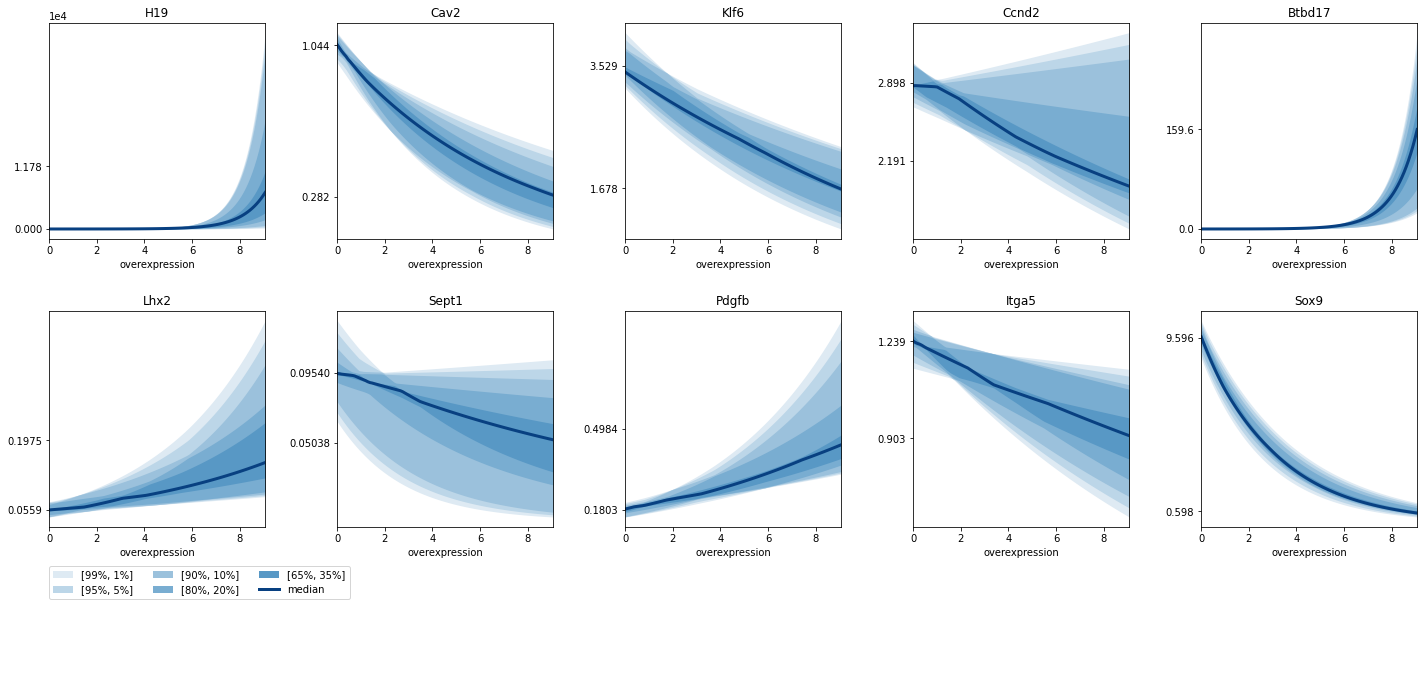

In [21]:
overexpression_causal.plot_features()

Note that if you don't specify any features to plot to `plot_features()` it will by default display the 10 features with the highest likelihood ratio.

This plot shows both the _median_ value of each gene across different doses of the transcription factor, together with several _credible intervals_ as shades areas. The credible interval shows, within the constraints of soft and hard priors, where the actual average value of the gene expression will lie.

::::{margin}
:::{seealso}
https://en.wikipedia.org/wiki/Credible_interval
:::
::::

Mathematically, this plot represents the conditional posterior:

$$P(\mu|\text{overexpression} = ...)$$

the probability distribution of the mean expression given the observed overexpression.

A causal posterior can also provide a score dataframe that will rank each _feature_ (gene). In this case, this also includes columns for the maximal fold change (`fc`), absolute change (`ab`) and peak input value (`peak`).

In [22]:
overexpression_causal.scores

,label,fc,ac,peak
gene,,,,
ENSMUSG00000000031,H19,25183.007812,11783.072266,9.073374
ENSMUSG00000000058,Cav2,3.703122,0.762329,0.000000
ENSMUSG00000000078,Klf6,2.103417,1.851230,0.000000
ENSMUSG00000000184,Ccnd2,1.322858,0.707333,0.000000
ENSMUSG00000000202,Btbd17,11143.601562,159.557343,9.073374
...,...,...,...,...
ENSMUSG00000117278,AC166110.4,5.030758,0.137543,9.073374
ENSMUSG00000117515,AC121783.1,1.673854,0.049874,9.073374
ENSMUSG00000117710,AC124502.1,1.471475,0.010614,0.000000


### 3. Perturbed posteriors

To understand whether a variable has an important impact on the downstream variable, we use perturbed posteriors. These posteriors work in a very similar way as the observed posterior, but rather than using the actual value of the variable, it uses a perturbed version. The type of perturbation varies depending on which question we want to address, and can include random shuffling, random sampling from the prior, or conditionalizing on a fixed value.

While you can independently construct a perturbed posterior, you will typically create it indirectly through a causal posterior. For example, we can do random sampling from the prior using:

In [23]:
overexpression_causal.sample_random()

  0%|          | 0/10 [00:00<?, ?it/s]

To check the impact of a variable on our observation, we calculate a (log-)likelihood ratio: how likely is the observed expression compared to a random result (where we randomly perturbed the upstream variable)?

In [24]:
overexpression_causal.likelihood_ratio

<xarray.DataArray (gene: 2047)>
array([431.80505  ,  81.74133  ,  58.1156   , ...,   5.119179 ,
         8.37426  ,   2.7610474], dtype=float32)
Coordinates:
  * gene     (gene) <U18 'ENSMUSG00000000031' ... 'ENSMUSG00000118365'

Mathematically, these values represents the ratio between posteriors probabilities:

$$\frac{P(\mu|\text{overexpression})}{P(\mu|\text{overexpression}_\text{shuffled})}$$

These likelihood ratios were also automatically added to our scores table:

In [25]:
overexpression_causal.scores.head()

,label,fc,ac,lr,peak
gene,,,,,
ENSMUSG00000026981,Il1rn,54.286900,7.395948,1878.719727,0.0
ENSMUSG00000047793,Sned1,22.343615,3.970792,1495.038574,0.0
ENSMUSG00000089774,Slc5a3,18.013126,6.062634,1387.124023,0.0
ENSMUSG00000000567,Sox9,16.059420,8.998875,1326.781006,0.0
ENSMUSG00000005360,Slc1a3,11.020549,15.373086,1248.582031,0.0


:::{note}
These likelihood ratios are mainly useful to understand the impact of a variable on an outcome *within a model*. In the model selection tutorial, we will introduce a better measure to quantify whether a variable **significantly** affects an outcome, by comparing it to other simpler or more complex models.
:::

### Empirical posteriors

Instead of moving down from our model, starting from latent variables towards observation, we can also to some extent move up the tree starting from the observations. For example, for transcriptomics data, we can move up from the observations through the NegativeBinomial2 distribution, towards the expression. To calculate  

In [26]:
overexpression_causal.observed.sample()

  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
overexpression_causal.sample_empirical()

An empirical posterior can be used to visualize the "empirical" values for a causal posterior:

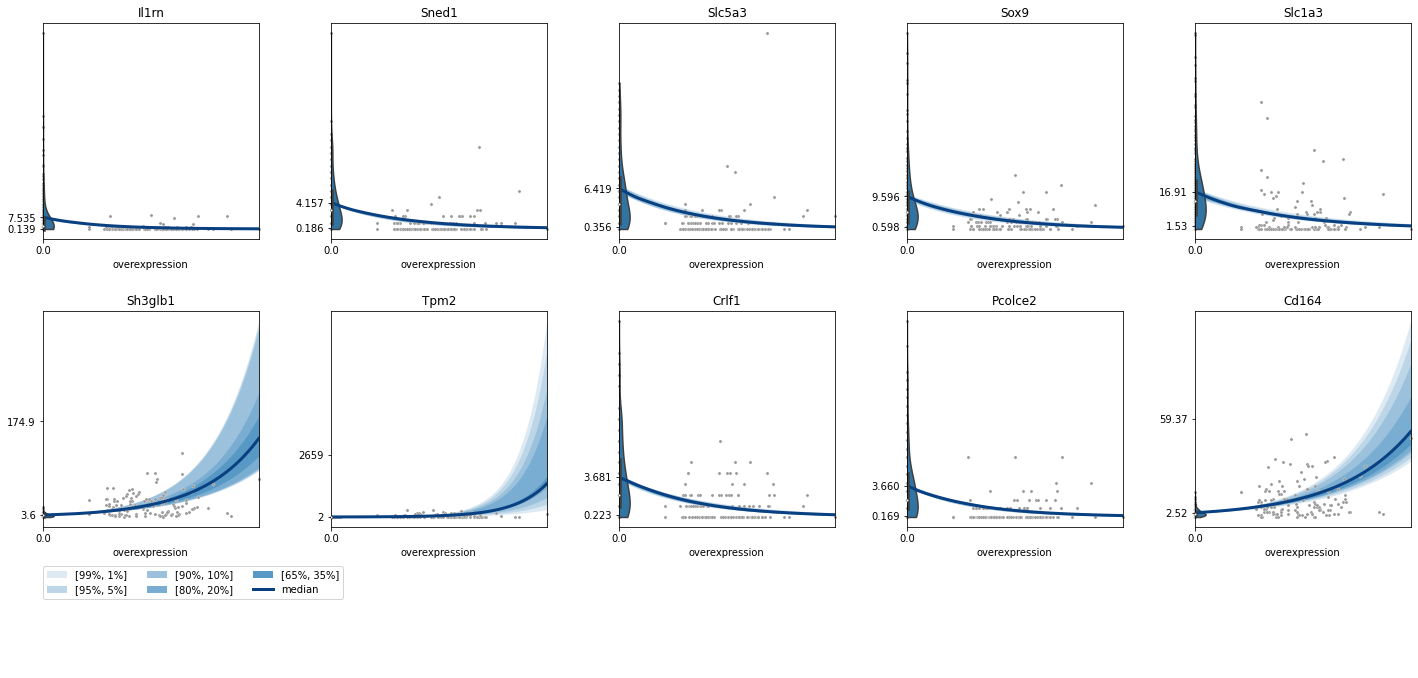

In [28]:
overexpression_causal.plot_features()

## Using _lacell_ to make model creation easier

Specific modalities in single-cell data typically require a similar way of normalization and statistical modelling, and we have collected such prototypical models into the `lacell` package. For example, we can directly construct a model for transcriptomics from an AnnData object as follows:

In [29]:
import lacell as lac

transcriptome = lac.transcriptome.TranscriptomeObservation.from_adata(adata)
transcriptome.plot()

Note that this model is a bit more complex that the model we created before. In particular, it contains a library size normalization that will normalize the counts of each gene within a cell to the cell's total counts. However, the main ideas remain the same. Let's go through the graph from bottom to top:

- We model the transcriptome as a negative binomial distributions, with a dispersion $\theta$ and mean $\mu$.
- The mean $\mu$ is modelled as a linear combination of the relative expression of a gene in a cell, $\rho$, and its library size, $\textit{lib}$. The library size is set to the empirical library size (i.e. simply the sum of the counts in each cell).
- The relative expression in a cell $\rho$ is itself a linear combination of the average expression (or baseline) of each gene in the cell, $\nu$, modelled as a latent variable, and the log-fold change $\delta$. Note: exp(log$\rho$ + $\delta$) = $\rho$\*exp($\delta$)
- When modelling cellular processes, we typically adapt the log-fold change $\delta$, that is why it is for now empty. However, you can also adapt any other variables, such as the library size or dispersion, if this makes sense from a biological or technical perspective.

:::{seealso}
[Why don't we just provide normalized data to latenta?](why-not-just-provide-normalized-data)
:::

Once models reach a certain complexity, it becomes easier to get a variable using the `find()` function, which will recursively look for an object with the given label or symbol:

In [30]:
foldchange = transcriptome.find("foldchange")
foldchange

foldchange:  ↦ Additive [cell (799), gene (2047)] = $0\require{action}$

Let’s adapt the model by adding the overexpression to the fold change:

In [31]:
foldchange.overexpression = la.links.scalar.Linear(
    overexpression, a=True, label="expression", definition=foldchange.value_definition
)

This modification is also done in automatically transcriptome.

Note that we do not transform this variable, nor do we add a baseline (or intercept) to this function as this is all handled downstream by the $\rho$ function

In [32]:
transcriptome.plot()

## Doing inference on other devices

:::{note}
See the [installation instructions](/tutorials/installation) for additional steps you may need to perform to make GPUs work
:::

You can check out the default device that is used on your system using:

In [33]:
la.config.device

'cuda'

Inference of models can be much faster on some GPUs using `cuda`, and this will be your default device if latenta detects that there is a GPU available. Even when working on a GPU, we typically still create and store our full model on the CPU memory, i.e. RAM. We only move the model to GPU when necessary for inference, where it will be stored on the GPU's memory, i.e. VRAM, which is typically much smaller than your regular RAM. We can do this for the full model by doing:

```python
transcriptome.to("cuda")
```

You will however typically temporarily switch a device to another device using a context manager, e.g.:

```python
with transcriptome.switch("cuda"):
    print(f"transcriptome is on device: {transcriptome.device}")
print(f"transcriptome is on device: {transcriptome.device}")
```

We will illustrate this for inference, in this case using latenta's default device:

In [34]:
with transcriptome.switch(la.config.device):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

  0%|                                                                                                         …

## Other regression problems

Until now we have considered the simple case where we model the relationship between the gene expression and the overexpression as linear. However we can perfectly imagine that this relationship is non-linear or we can have other types of variables that are discrete.

### Non-linear

To consider non-linear relationships, we can use any of the non-linear link functions implemented in latenta:

In [35]:
import pandas as pd
import IPython.display

links = [la.links.scalar.Logistic, la.links.scalar.Spline, la.links.scalar.Sigmoid]

link_table = []
for link in links:
    link_table.append(
        {
            "name": link.__name__,
            "reference": "`" + link.__module__ + "." + link.__name__ + "`",
            "description": link.__doc__.strip().split("\n")[0],
        }
    )
link_table = pd.DataFrame(link_table)
IPython.display.HTML(link_table.to_html())

,name,reference,description
0,Logistic,`latenta.links.scalar.sigmoid.Logistic`,Logistic function:
1,Spline,`latenta.links.scalar.spline.Spline`,"Smooth, one dimensional, spline."
2,Sigmoid,`latenta.links.scalar.sigmoid.Sigmoid`,Standard sigmoid kinetics:


We'll now illustrate a regression using a Spline function:

We can basically do as we just did for the fold change but using {class}`latenta.links.scalar.Spline()`:

In [36]:
foldchange.overexpression = la.links.scalar.Spline(
    overexpression,
    label="expression",
    definition=foldchange.value_definition,
    transforms=[la.transforms.Exp()],
)

In [37]:
transcriptome.plot()

Let's now run the inference as previously:

In [38]:
with transcriptome.switch(la.config.device):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

  0%|                                                                                                         …

In [39]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression, transcriptome
)
overexpression_causal.observed.sample()
overexpression_causal.sample(30)
overexpression_causal.sample_empirical()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

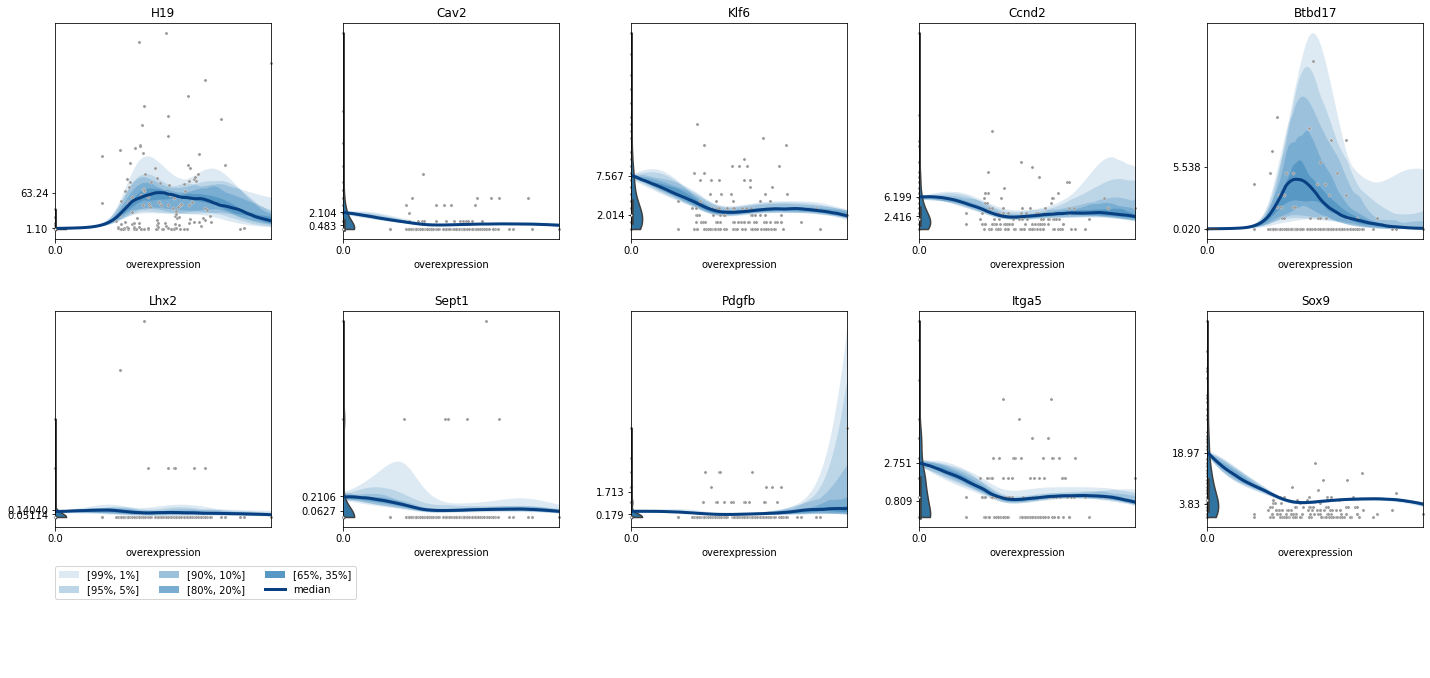

In [40]:
overexpression_causal.plot_features()

### Discrete

To model discrete (or categorical) variables, we first have to convert it to a "one-hot" encoding, where each cells and categories are located in respectively rows and columns, and where a 1 indicates membership to the category. We can use the {class}`la.variables.DiscreteFixed` helper for this purpose which expects a pandas categorical variable as input.

Let's add the batch to the model:

In [41]:
batch = la.variables.DiscreteFixed(adata.obs["batch"].astype("category"))

In [42]:
batch.prior_pd().head()

batch,A,B,C
cell,,,
AAAGATGAGGCAATTA-1-5,1.0,0.0,0.0
AAATGGAGTACGTACT-1-7,0.0,1.0,0.0
AAGACTCTCCGCACTT-1-9,0.0,0.0,1.0
AAGGTAATCCTATTTG-1-8,0.0,1.0,0.0
AATCGACTCGTTCTGC-1-7,0.0,1.0,0.0


:::{seealso}
You can convert a pandas Series to categorical using `series = series.astype("category")`. The `series.cat` accessor contains many functions to access and change the categories, see https://pandas.pydata.org/docs/user_guide/categorical.html
:::

To calculate the batch effect, we want to multiply this one-hot encoding with another matrix in which each combination of batch and gene has a value that represents the fold difference in a particular batch. This is a perfect case for a matrix multiplication `latenta.links.vector.Matmul()`:

In [43]:
foldchange.batch = la.links.vector.Matmul(batch, definition=foldchange.value_definition)
transcriptome.plot()

The latent variable in this case contains one value for each gene and batch. The matrix multiplication will for each combination of cells and genes multiply and sum all the values for each batch.

:::{note}
In constrast to the previous link functions we have seen, this time around our link function is included in the `la.links.vector` module. The reason for this is that we are processing the input by vector (i.e. the batch status of each cell). `la.links.vector` contains many other link functions that work in a similar fashion, for example to scale and center data across a dimension.
:::

### Multiple regression

Let's say we wanted to find out how both the overexpression and the cell cycle affect the transcriptome. A naive way of doing that would be to use the canonical S and G2M scores as input for a linear regression. These scores are based on the expression of specific genes known to be linked to S or G2M phase (REFERENCE).

In [44]:
cellcycle_genes = lac.transcriptome.effects.cellcycle.get_cellcycle_genes(organism="mm")
sc.tl.score_genes_cell_cycle(
    adata,
    cellcycle_genes.query("phase == 'S'")["gene"],
    cellcycle_genes.query("phase == 'G2/M'")["gene"],
)

The results are stored in `.obs`:

In [45]:
adata.obs["S_score"].head()

cell
AAAGATGAGGCAATTA-1-5   -0.680854
AAATGGAGTACGTACT-1-7   -0.988908
AAGACTCTCCGCACTT-1-9   -1.139981
AAGGTAATCCTATTTG-1-8   -0.823246
AATCGACTCGTTCTGC-1-7   -0.648782
Name: S_score, dtype: float64

Let's now adapt the foldchange from the transcriptome model already pre-constructed from `lacell`:

In [46]:
transcriptome = lac.transcriptome.TranscriptomeObservation.from_adata(adata)
foldchange = transcriptome.find("foldchange")

In [47]:
foldchange

foldchange:  ↦ Additive [cell (799), gene (2047)] = $0\require{action}$

Note that the foldchange is here an additive modular variable, which means that every components we add to foldchange will be automatically combined in a linear model:

In [48]:
overexpression = la.Fixed(adata.obs["log_overexpression"], label="overexpression")
foldchange.overexpression = la.links.scalar.Linear(
    overexpression, a=True, definition=foldchange.value_definition
)

In [49]:
S = la.Fixed(adata.obs["S_score"])
foldchange.S = la.links.scalar.Linear(S, a=True, definition=foldchange.value_definition)

G2M = la.Fixed(adata.obs["G2M_score"])
foldchange.G2M = la.links.scalar.Linear(
    G2M, a=True, definition=foldchange.value_definition
)

In [50]:
foldchange.plot()

:::{warning}
Given that the cell cycle is a circular process, this way of modelling the cell cycle has a lot of flaws. This is merely included here for illustration purposes.
:::

Let's once again perform the inference:

In [51]:
with transcriptome.switch(la.config.device):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

  0%|                                                                                                         …

We can now observed the posterior for the overexpression:

In [52]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression, transcriptome
)
overexpression_causal.observed.sample()
overexpression_causal.sample(30)
overexpression_causal.sample_empirical()
overexpression_causal.sample_random()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

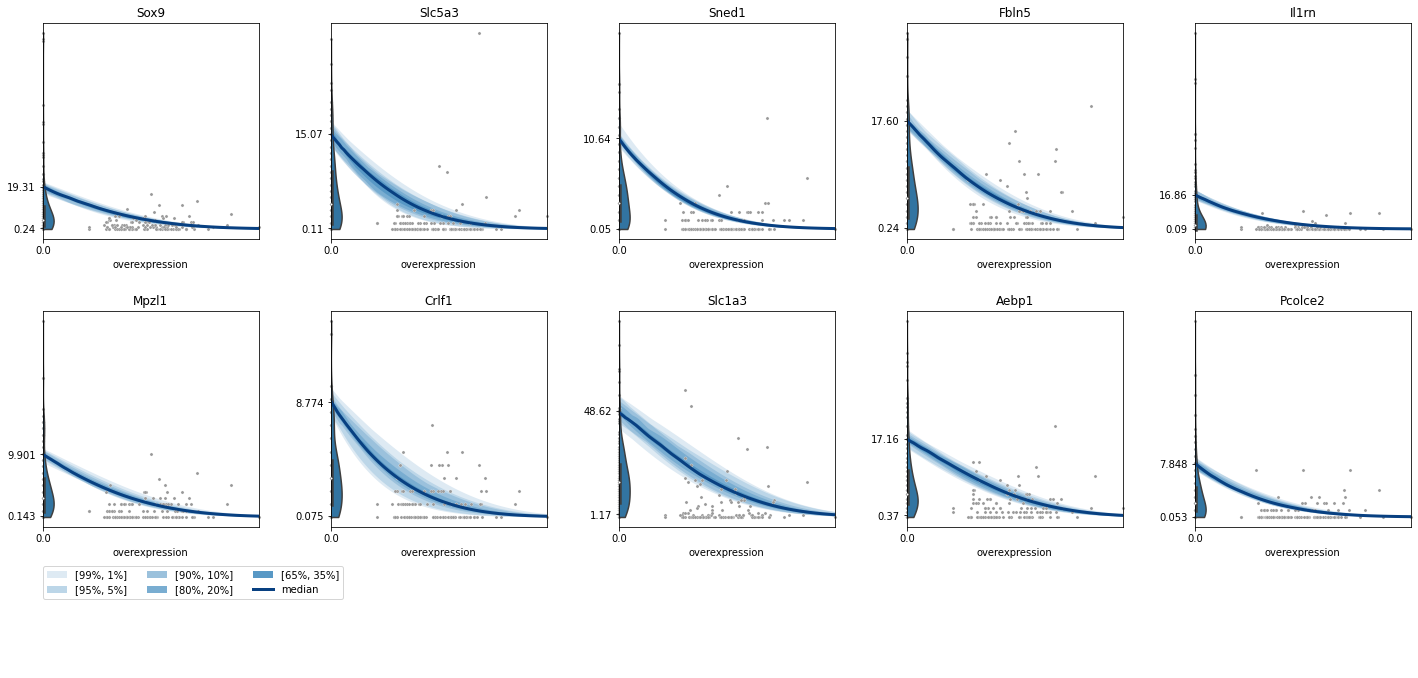

In [53]:
overexpression_causal.plot_features()

But also for the different cycle phases:

In [54]:
G2M_causal = la.posterior.scalar.ScalarVectorCausal(G2M, transcriptome)
G2M_causal.observed.sample()
G2M_causal.sample(30)
G2M_causal.sample_empirical()
G2M_causal.sample_random()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

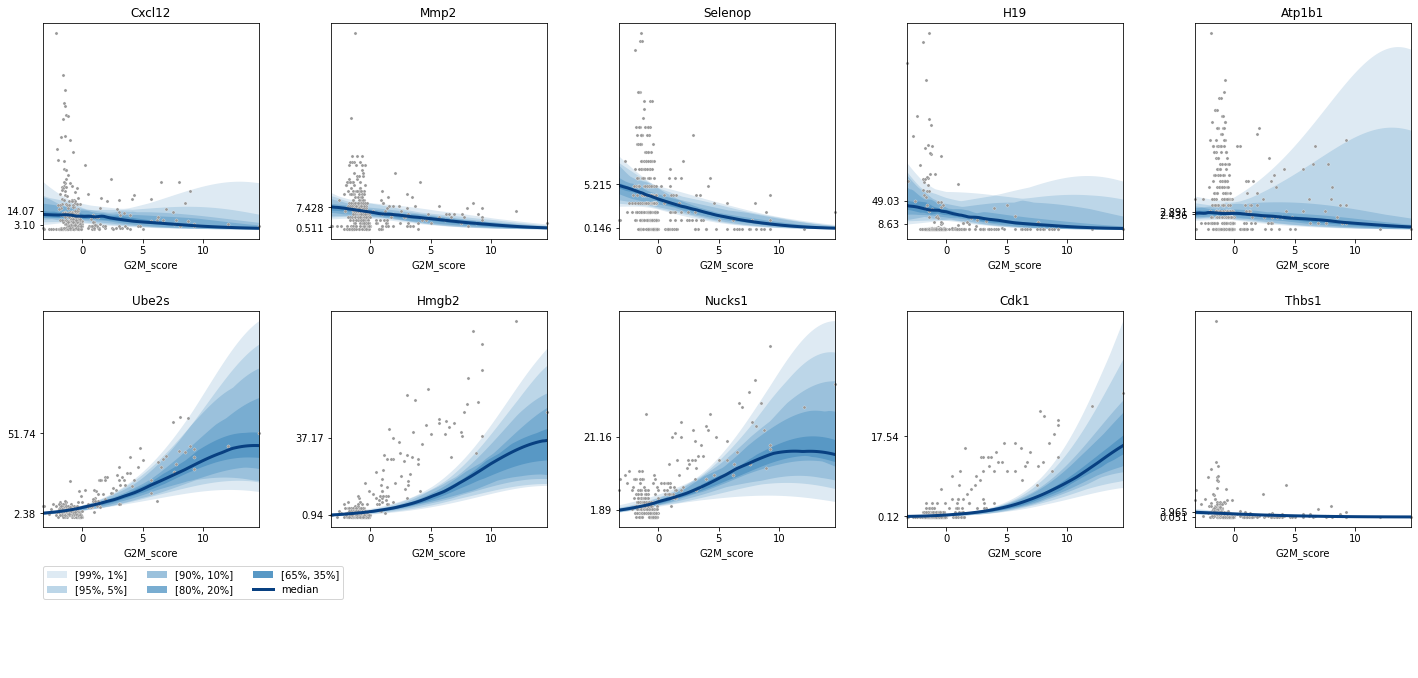

In [55]:
G2M_causal.plot_features()

In [56]:
S_causal = la.posterior.scalar.ScalarVectorCausal(S, transcriptome)
S_causal.observed.sample()
S_causal.sample(30)
S_causal.sample_empirical()
S_causal.sample_random()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

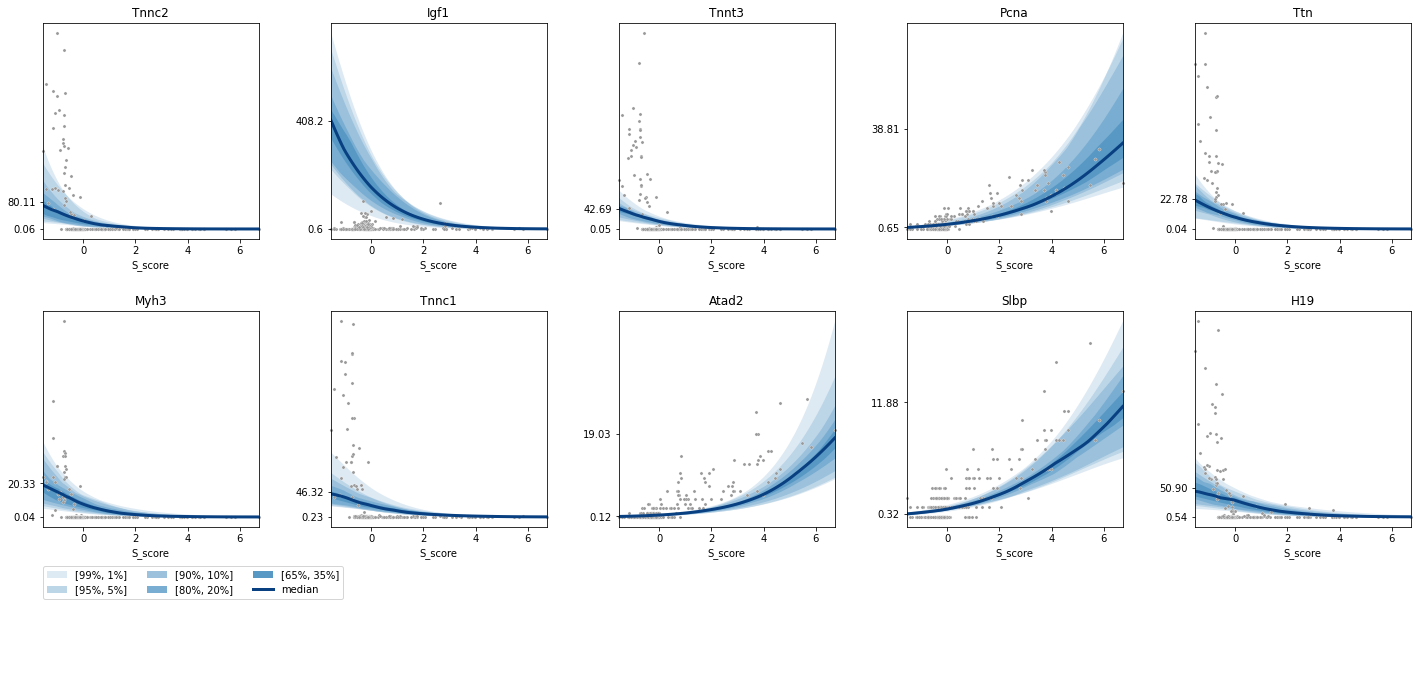

In [57]:
S_causal.plot_features()

## Main points

- Inferring a model means finding the optimal values for the free parameters
- The optimal value of parameters is defined by the loss function. In our case, this loss function tries to find a good balance between:
   - The wishes of the observations, i.e. to have the highest likelihood possible
   - The wishes of the latent variables, which want the variational distribution $q$ to resemble the prior distribution $p$ as best as possible
- To find optimal values, we typically perform gradient descent
- To interpret a model, we sample from the posterior and track intermediate values and/or probabilities:
   - An observed posterior is used to check out the values of one variable, such as the observations or latent variables
   - A causal posterior is used to check out the effect of one variable on another, such as how a latent variable affects the mean of an observation's distribution
   - A perturbed posterior is used to quantify the effect that one variable has on the likelihood of another, such as how a latent variable affects an observation
- _lacell_ contains many modules that make the creation of models for single-cell omics easier
- With latenta we can also do non-linear regression, use multiple variables as input, and/or discrete variables as input